In [74]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import ALookAtTheData as t
from IPython import display
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#read csv files from Kaggle for Boston listings
#https://www.kaggle.com/airbnb/boston?select=listings.csv
#NOTE: file renamed from listings.csv to boston_listings.csv
df_b_list = pd.read_csv('boston_listings.csv')
#df_b_list.head()

In [75]:
#code found on https://pbpython.com/currency-cleanup.html. converts price to float after removing $
#futurewarning about value of regex when runs but still produces results; 
#for the sake of timely completion of this assignment, will ignore error for now and make changes in the future as needed
df_b_list['price'] = pd.to_numeric(df_b_list['price'].str.replace("$", "").str.replace(",", ""), errors = "ignore")

<ipython-input-75-341bbc98973d>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_b_list['price'] = pd.to_numeric(df_b_list['price'].str.replace("$", "").str.replace(",", ""), errors = "ignore")


In [76]:
#sample larger values to ensure dollar sign and comma removed. price field also now float instead of object
df_b_list.price.loc[df_b_list['price'] > 999]

793     1400.0
1022    1300.0
1262    1250.0
1764    1000.0
1896    1235.0
1950    1345.0
2204    1372.0
2285    4000.0
2448    1275.0
3055    3000.0
3096    1250.0
3242    1000.0
Name: price, dtype: float64

In [77]:
#3,585 total records
df_b_list.shape

(3585, 95)

In [121]:
df_b_list.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [194]:
#dataframes for three questions/sets
df_1 = df_b_list[['price', 'bedrooms', 'bathrooms','room_type']] #question 1 and 2
df_3 = df_b_list[['price', 'neighbourhood_cleansed']] #question 3
df_4 = df_b_list[['room_type', 'calendar_updated', 'availability_90']] #question 4

In [195]:
df_1

,price,bedrooms,bathrooms,room_type
0,250.0,2.0,1.5,Entire home/apt
1,65.0,1.0,1.0,Private room
2,65.0,1.0,1.0,Private room
3,75.0,1.0,1.0,Private room
4,79.0,1.0,1.5,Private room
...,...,...,...,...
3580,69.0,1.0,1.0,Private room
3581,150.0,1.0,1.0,Private room
3582,198.0,1.0,1.0,Entire home/apt
3583,65.0,1.0,1.0,Private room


In [196]:
#for set 1 and 2 identify only Entire home/apartments (rooms for rent may skew metrics)
df_1 = df_1[df_1.room_type == 'Entire home/apt']

In [197]:
#drop room type field (no longer needed)
df_1.drop('room_type', axis=1, inplace=True)

In [198]:
####################################################
####################################################
####################################################
####################################################
#CODING FOR QUESTIONS 1 and 2:
#Question 1: Is there high or low variance between the mean price per bedroom/bathroom and observed list prices (entire units)?
#Question 2: As the number of bedrooms increase does list price increase? What about number of bathrooms (entire units)?
#check data types, set 1. Price set to y; Bedrooms, Bathrooms, Beds set to X 
#Expect all datatypes as numeric/non-categorical. Checks out....
df_1.dtypes

price        float64
bedrooms     float64
bathrooms    float64
dtype: object

In [199]:
#stats on dataset. Small population size. Most units 1 bedroom, 1-2 bathrooms, 1 bed. small number of X values missing
#NOTE: I thought about concatenating bedrooms + bathrooms + beds into 1 categorical variable and using pandas.get_dummies(), 
       #but the population is small (I didn't think this would be a good approach).
#NOTE2: the min value vs 25th percentile and 
       #max value vs 75th percentile shows outliers (chart below). I want to remove outliers to improve the mean and plots. 
       #I don't want to remove too much data so I found and modified a script to remove records 
       # having list prices outside the 95th and 5th percentiles (next cell)
df_1.describe()

,price,bedrooms,bathrooms
count,2127.000000,2117.000000,2123.000000
mean,227.436765,1.432215,1.248940
std,157.852765,0.938950,0.486474
min,11.000000,0.000000,0.000000
25%,150.000000,1.000000,1.000000
50%,199.000000,1.000000,1.000000
75%,269.000000,2.000000,1.000000
max,4000.000000,5.000000,5.000000


In [200]:
#set 1 (for questions 1 and 2) identify records with prices below 5th and above 95th percentiles, remove....
cols = ['price'] # one or more
#code found here: 
#https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles

Q1 = df_1[cols].quantile(0.05)
Q3 = df_1[cols].quantile(0.95)
IQR = Q3 - Q1

df_1 = df_1[~((df_1[cols] < (Q1 - 1.5 * IQR)) |(df_1[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [201]:
#code in the prior cell removed outliers; only 10 records removed.
df_1.describe()

,price,bedrooms,bathrooms
count,2117.000000,2107.000000,2113.000000
mean,220.785546,1.429046,1.245386
std,105.839092,0.936275,0.478722
min,11.000000,0.000000,0.000000
25%,150.000000,1.000000,1.000000
50%,199.000000,1.000000,1.000000
75%,269.000000,2.000000,1.000000
max,849.000000,5.000000,5.000000


In [202]:
#Price (y) no nulls; X values show small number of null values, < 1%. However, dataset 3.5K (small set to begin with)
#Makes more sense to impute X values with mean so we do not lose value
(np.sum(df_1.isnull() == True)/df_1.shape[0])*100

price        0.000000
bedrooms     0.472367
bathrooms    0.188947
dtype: float64

In [203]:
#identify null bathroom rows (will check before/after rows filled with mean)
#check row 755 after
df_1[df_1['bathrooms'].isna()]

,price,bedrooms,bathrooms
755,99.0,1.0,NaN
800,167.0,1.0,NaN
888,163.0,1.0,NaN
2201,349.0,2.0,NaN


In [204]:
#identify null bedroom rows (will check before/after rows filled with mean)
#check row 918 after
df_1[df_1['bedrooms'].isna()]

,price,bedrooms,bathrooms
918,176.0,NaN,1.0
920,229.0,NaN,1.0
924,275.0,NaN,1.0
1095,186.0,NaN,1.0
1117,269.0,NaN,1.0
1132,225.0,NaN,1.0
1251,209.0,NaN,1.0
1366,209.0,NaN,1.0
1419,209.0,NaN,1.0
1959,175.0,NaN,1.0


In [205]:
# Fill null numeric columns with the mean.
# Ignore SettingWithCopyWarning code from stackoverflow:
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  
num_vars = df_1.select_dtypes(include=['float64', 'int']).columns
for col in num_vars:
    df_1a = df_1[col].fillna((df_1[col].mean()), inplace=True)

In [206]:
#validate nulls no longer exist (no nulls exist)
np.sum(df_1.isnull() == True)

price        0
bedrooms     0
bathrooms    0
dtype: int64

In [207]:
#spot check row 755 (null bathroom) is now imputed with mean...checks out
df_1.loc[755]

price        99.000000
bedrooms      1.000000
bathrooms     1.245386
Name: 755, dtype: float64

In [210]:
#spot check row 918 (null bedroom) is now imputed with mean ...checks out
df_1.loc[918]

price        176.000000
bedrooms       1.429046
bathrooms      1.000000
Name: 918, dtype: float64

In [211]:
df_1.describe()

,price,bedrooms,bathrooms
count,2117.000000,2117.000000,2117.000000
mean,220.785546,1.429046,1.245386
std,105.839092,0.934060,0.478270
min,11.000000,0.000000,0.000000
25%,150.000000,1.000000,1.000000
50%,199.000000,1.000000,1.000000
75%,269.000000,2.000000,1.000000
max,849.000000,5.000000,5.000000


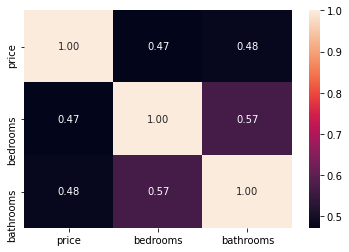

In [212]:
#Heatmap to show correlation of price to rooms
#similar correlation between price and number of bedrooms/bathrooms
sns.heatmap(df_1.corr(), annot=True, fmt=".2f");

In [213]:
#create model with several outpus for plotting and testing in case ML model is used. function modified from:
# https://github.com/udacity/DSND_Term2/blob/master/lessons/CRISP_DM/Categorical%20Variables%20-%20Solution.ipynb
def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=42):


    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds, X, y


#create output sets
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds, X, y = clean_fit_linear_mod(df_1, 'price')

In [214]:
#training and testing R squared score.  
#looks like the training model is overfitting. thought about using Ridge/lasso; but at this point will not use model
#and instead will plot X and y on scatterplot 
# 
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.2604102832378733.  The rsquared on the test data was 0.35495433947701327.


Text(0.5, 1.0, 'Price to # of Bedrooms Plot')

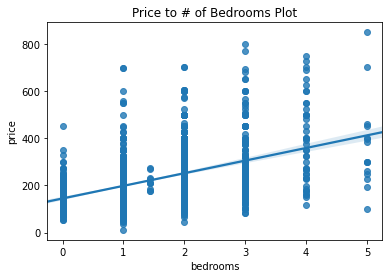

In [215]:
#plot bedrooms to pricing with seaborn 
sns.regplot(x=X['bedrooms'], y=y, truncate = False).set_title('Price to # of Bedrooms Plot')

Text(0.5, 1.0, 'Price to # of Bathrooms Plot')

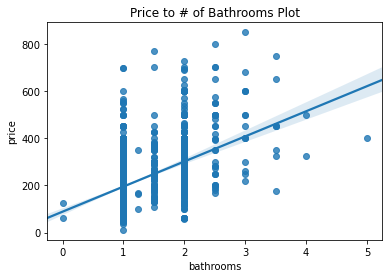

In [216]:
#plot bathrooms to pricing with seaborn (looks cleaner)
sns.regplot(x=X['bathrooms'], y=y, truncate = False).set_title('Price to # of Bathrooms Plot')

In [217]:
#descriptive stats to compliment scatterplots (# of bedrooms to pricing)
df_1_mean= df_1.groupby(df_1.bedrooms) \
.agg(
     mean_price=pd.NamedAgg(column='price', aggfunc='mean'), \
     med_price=pd.NamedAgg(column='price', aggfunc='median'), \
     cnt_listings=pd.NamedAgg(column='price', aggfunc='count'), \
     min_price=pd.NamedAgg(column='price', aggfunc='min'),  \
     max_price=pd.NamedAgg(column='price', aggfunc='max'),  \
    )
#sorted descriptive stats by mean price highest to lowest
df_1_mean.sort_values("mean_price", ascending=False)

,mean_price,med_price,cnt_listings,min_price,max_price
bedrooms,,,,,
4.000000,389.400000,375.0,45,115.0,750.0
5.000000,370.933333,300.0,15,100.0,849.0
3.000000,305.849673,279.0,153,84.0,800.0
2.000000,252.668116,247.0,690,45.0,700.0
1.429046,216.200000,209.0,10,175.0,275.0
1.000000,192.615049,180.0,917,11.0,699.0
0.000000,154.668990,150.0,287,55.0,450.0


In [218]:
#descriptive stats to compliment scatterplots (# of bathrooms to pricing)
df_1_mean= df_1.groupby(df_1.bathrooms) \
.agg(
     mean_price=pd.NamedAgg(column='price', aggfunc='mean'), \
     med_price=pd.NamedAgg(column='price', aggfunc='median'), \
     cnt_listings=pd.NamedAgg(column='price', aggfunc='count'), \
     min_price=pd.NamedAgg(column='price', aggfunc='min'),  \
     max_price=pd.NamedAgg(column='price', aggfunc='max'),  \
    )
#sorted descriptive stats by mean price highest to lowest
df_1_mean.sort_values("mean_price", ascending=False)

,mean_price,med_price,cnt_listings,min_price,max_price
bathrooms,,,,,
3.000000,466.866667,450.0,15,219.0,849.0
3.500000,450.000000,450.0,8,175.0,750.0
4.000000,412.500000,412.5,2,325.0,500.0
2.500000,404.729730,395.0,37,168.0,800.0
5.000000,399.000000,399.0,1,399.0,399.0
2.000000,289.395543,279.0,359,59.0,725.0
1.500000,277.152174,255.0,92,110.0,769.0
1.245386,194.500000,165.0,4,99.0,349.0
1.000000,194.268629,180.0,1597,11.0,699.0


In [101]:
#Conclusion Question 1: 
#Variance is high when comparing the mean list price per bedrooms and bathrooms to actual observed listings.
#looking at the chart from Question 3 (Can we provide Airbnb owners typical rental prices in different Boston neighborhoods?)
#this variance can be explained by variation in pricing depending on  neighborhood in Boston.
#After 2.5 bathrooms variance increases (could be incorrect listings, small number of listings in categories)
####################################################
#Conclusion Question 2: 
#good positive relationship exists for increase in price and increase in number of bedrooms.
#spotty relationship exists between increase in price and increase in bathrooms; data is inconsistent
#3 bathroom units pricing > 3.5 bathroom units (small data size could be the issue)
#pricing for 1-2.5 bathrooms shows a decent relationship
####################################################
####################################################
####################################################
####################################################
#END Question 1 and 2..........................................

In [98]:
####################################################
####################################################
####################################################
####################################################
#Question 3: Can we provide Airbnb owners typical rental prices in different Boston neighborhoods?

#neighborhood_cleansed (neighborhood) field has no null values; will not need to remove nulls. 
(np.sum(df_3.isnull() == True)/df_3.shape[0])*100

price                     0.0
neighbourhood_cleansed    0.0
dtype: float64

In [103]:
#set 3 (for question 3) identify records with prices below 5th and above 95th percentiles, remove....
cols = ['price'] # one or more
#code found here: 
#https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles

Q1 = df_3[cols].quantile(0.05)
Q3 = df_3[cols].quantile(0.95)
IQR = Q3 - Q1

df_3 = df_3[~((df_3[cols] < (Q1 - 1.5 * IQR)) |(df_3[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

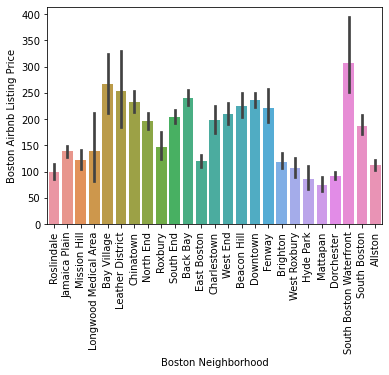

,mean_price,med_price,cnt_listings,min_price,max_price
neighbourhood_cleansed,,,,,
South Boston Waterfront,306.060241,245.0,83,115.0,3000.0
Bay Village,266.833333,206.5,24,90.0,500.0
Leather District,253.600000,245.0,5,159.0,390.0
Back Bay,240.950331,209.0,302,40.0,1250.0
Downtown,236.459302,225.0,172,10.0,600.0
Chinatown,232.352113,219.0,71,80.0,399.0
Beacon Hill,224.443299,195.0,194,75.0,1345.0
Fenway,220.393103,191.0,290,30.0,4000.0
West End,209.591837,199.0,49,60.0,450.0


In [223]:
#price per Boston neighborhood, seaborn barplot, unsorted
sns.barplot(x = 'neighbourhood_cleansed', y = 'price', data = df_3)
plt.ylabel('Boston Airbnb Listing Price')
plt.xlabel('Boston Neighborhood')
plt.xticks(rotation=90)
plt.show()

#descriptive stats
df_3_mean= df_3.groupby(df_3.neighbourhood_cleansed) \
.agg(
     mean_price=pd.NamedAgg(column='price', aggfunc='mean'), \
     med_price=pd.NamedAgg(column='price', aggfunc='median'), \
     cnt_listings=pd.NamedAgg(column='price', aggfunc='count'), \
     min_price=pd.NamedAgg(column='price', aggfunc='min'),  \
     max_price=pd.NamedAgg(column='price', aggfunc='max'),  \
    )
#sorted descriptive stats by median price highest to lowest (may be a better indicator of category (high to low) than mean)
df_3_mean.sort_values("mean_price", ascending=False)

In [107]:
#Question 3 Analysis findings: 
#Outliers may skew results; should be careful when drawing conclusions:
#Example1 Downtown has a min price of $10 (could be driving the average lower; could be an error in the listing)
#Example2 Leather district has 5 listings, but min listing still relatively high (may not be an issue) 
#Conclusion: after removing outliers (< 5th percentile, > 95th percentile) mean should be good to show rental prices high>low
####################################################
####################################################
####################################################
####################################################
#END QUESTION 3..........................................

In [108]:
####################################################
####################################################
####################################################
####################################################
#QUESTION 4: Can we provide feedback on rental type demand (IE, are rooms/shared rooms/full units in higher demand)?

#no null values; will not need to remove nulls. 
(np.sum(df_4.isnull() == True)/df_4.shape[0])*100

room_type           0.0
calendar_updated    0.0
availability_90     0.0
dtype: float64

In [109]:
#3,585 total records
df_4.shape

(3585, 3)

In [110]:
#a smaller number of listings not updated in several months, some never updated. This may affect availability since 
#listings may be inaccurate or never used/under-utilized. We will remove listings not updated within 6 months
df_4.calendar_updated.value_counts(ascending=True)

22 months ago      1
20 months ago      1
23 months ago      1
30 months ago      1
25 months ago      2
18 months ago      2
16 months ago      7
15 months ago      8
17 months ago      9
12 months ago     13
11 months ago     17
never             19
13 months ago     19
14 months ago     19
6 months ago      32
8 months ago      32
9 months ago      35
6 days ago        36
1 week ago        36
10 months ago     37
7 weeks ago       37
7 months ago      43
5 months ago      56
6 weeks ago       81
4 months ago      85
2 days ago        98
3 days ago       101
5 weeks ago      128
3 months ago     131
5 days ago       132
4 weeks ago      158
2 months ago     165
4 days ago       168
yesterday        174
3 weeks ago      221
2 weeks ago      307
a week ago       340
today            833
Name: calendar_updated, dtype: int64

In [111]:
#create drop list and drop rows with older/missing calander_updated values
#code idea from https://www.codegrepper.com/code-examples/python/how+to+drop+rows+with+specific+value+in+pandas
drop_list = ['23 months ago','20 months ago','30 months ago','22 months ago','25 months ago','18 months ago','16 months ago','15 months ago','17 months ago','12 months ago','11 months ago','never','13 months ago','14 months ago','8 months ago','9 months ago','10 months ago','7 months ago']
df_4.drop(df_4.index[df_4['calendar_updated'].isin(drop_list)], inplace = True)

In [112]:
#verify list of values removed
df_4.calendar_updated.value_counts(ascending=True)

6 months ago     32
6 days ago       36
1 week ago       36
7 weeks ago      37
5 months ago     56
6 weeks ago      81
4 months ago     85
2 days ago       98
3 days ago      101
5 weeks ago     128
3 months ago    131
5 days ago      132
4 weeks ago     158
2 months ago    165
4 days ago      168
yesterday       174
3 weeks ago     221
2 weeks ago     307
a week ago      340
today           833
Name: calendar_updated, dtype: int64

In [220]:
#drop calendar_updated field (no longer needed)
df_4.drop('calendar_updated', axis=1, inplace=True)

In [221]:
#verify column dropped
df_4

,room_type,availability_90
0,Entire home/apt,0
1,Private room,84
2,Private room,61
3,Private room,26
4,Private room,59
...,...,...
3580,Private room,81
3581,Private room,89
3582,Entire home/apt,40
3583,Private room,5


In [222]:
#statistics for Question 4
df_4_mean= df_4.groupby(df_4.room_type) \
.agg(
    mean_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='mean'), \
     med_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='median'), \
     cnt_rentals=pd.NamedAgg(column='availability_90', aggfunc='count'), \
     min_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='min'),  \
     max_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='max'),  \
     std_dev=pd.NamedAgg(column='availability_90', aggfunc='std'),
    )
#sorted by median price highest to lowest (may be a better indicator of category (high to low) than mean)
df_4_mean.sort_values("mean_avail_90days", ascending=False)

,mean_avail_90days,med_avail_90days,cnt_rentals,min_avail_90days,max_avail_90days,std_dev
room_type,,,,,,
Shared room,48.525000,58,80,0,90,36.656453
Entire home/apt,38.960508,38,2127,0,90,33.115215
Private room,37.358491,35,1378,0,90,32.924165


In [144]:
#Analysis of question 4: private rooms have the least days available in a 90 day period (lower median/mean availability)
# Followed by Entire home/apt, followed by shared room (least demand)
# Entire homes/apt's and Private rooms have a healthy population size; shared rooms do not (may not be as reliable)
#private rooms standard deviation the lowest of three types (most reliable); least reliable stdev = shared rooms
#CONCLUSION: private rooms are the most in demand room types for Airbnb listings in Boston
#shared rooms are least in demand for Airbnb listings in Boston
####################################################
####################################################
####################################################
####################################################
#END Question 4..........................................